For this first trial we assume a naive model (LGM) defined as:
$$dx_t = \sigma_t dW_t^{\mathit{N}}$$

Let's define the Numeraire as:
$$N(t, x_t) = \frac{1}{B(0,t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where $H_t$ and $\zeta_t$ are known functions.

With this let's defined the fundamental equation for the pricing of a derivative under the model. The NPV (Net Present Value) is:
$$V_t = V(t, x_t)$$ 
and the deflated version 
$$\overline{V}_t = V(t, x_t) / N(t, x_t)$$

#### Montecarlo simulation

* Brownian path:
$$W_t \sim \mathcal{N}(0,t)$$
$$W[0] = X_0$$
$$W[t] = W[t - 1]  + \mathcal{Z} \cdot \Delta t^{\frac{1}{2}}$$
with 
$$\mathcal{Z} \sim \mathcal{N}(0,1)$$
* X:
$$X_{t + 1} = X_t + \sigma \cdot (W_{t + 1} - W_t)$$

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from utils.simulator.simulator import MCSimulation

In [122]:
# Strike value
Vt = 2
T = 5
# Set of parameters
T, N_steps, X0, sigma = (T, 100, 0, 0.01)
mcsimulator = MCSimulation(T, N_steps, X0, sigma)
nsims = int(1e4)
test_sims = int(nsims * 0.2)
# Training
mc_paths, W = mcsimulator.simulate(nsims)
mc_paths_transpose = mc_paths.T
mc_paths_flatten = mc_paths.flatten('C')
w_paths_flatten = W.flatten('C')
# Test
mc_paths_test, W_test = mcsimulator.simulate(test_sims)
mc_paths_test_transpose = mc_paths_test.T
mc_paths_test_flatten = mc_paths_test.flatten('C')
w_paths_test_flatten = W_test.flatten('C')
# Deltas
deltaTs = np.linspace(0, T, N_steps)
simulations = np.linspace(0, nsims - 1, nsims)
simulations = np.int32(np.tile(simulations, N_steps))
deltaTs = np.tile(deltaTs.reshape(N_steps, 1), nsims).flatten()
df_x = pd.DataFrame(zip(
    deltaTs,
    mc_paths_flatten,
    w_paths_flatten,
    simulations
), columns = ['dt',
              'xt',
              'wt',
              'simulation'])

#### Visualization

In [123]:
deltaTs = np.linspace(0, T, N_steps)

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
if nsims < 101:
    plt.figure(figsize = (15,6))
    plt.title('Complete set of paths')
    sns.lineplot(x = 'dt', y = 'xt', hue = 'simulation', data = df_x)
    plt.show()
    plt.figure(figsize = (15,6))
    plt.title('Complete paths distribution')
    sns.regplot(x = 'dt', y = 'xt', data = df_x, scatter = False)
    plt.show()

#### Sanity with zero bond coupon

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ given and follows = $D(t) = e^{-rt}$, in this example with $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Discount factor (bono cupón 0 que paga 1 en T):

$$Z(x_t, t, T) = \frac{D(T)}{D(t)}exp-((H_T - H_t)x_t - \frac{1}{2}(H_T^2-H_t^2)\zeta_t) = \frac{D(T)}{D(t)}exp(-(H_T - H_t)x_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = $$
$$\frac{D(T)}{D(t)}exp(-H_Tx_t + H_tx_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = \frac{D(T)}{D(t)}exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)exp(H_tx_t + \frac{1}{2}H_t^2\zeta_t) = $$
$$D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

The sanity aims to retrieve the $D(t)$ after aggregating for each time step $t$ on the previous simulations. Steps:
* Calculate $Z(\cdot)$ for each timestep
* Calculate the numeraire $N(\cdot)$
* Get the $\hat{D}(t)$ for each path and time step as $\hat{D}(t) = \frac{Z(\cdot)}{N(\cdot)} \to E[\hat{D}(t)] = D(t)E[exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)] = D(T)exp(E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t]) = D(T)$
* Aggregate and compare the value with the theoretical $D(t)$

The final objective is to check that $E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t] = 0$

NOTE: $E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t] = -\frac{1}{2}H_T^2\zeta_t-H_TE[x_t]$

In [125]:
from utils.utils.utils import FinanceUtils, ZeroBound
t_unique = df_x.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = sigma) for dt in t_unique}
df_x['ct'] = df_x.apply(lambda x: dict_C[x['dt']], axis = 1)
xt, t, T, ct = df_x.xt, df_x.dt, T, df_x.ct
df_x['d_hat_t'] = ZeroBound.Z(xt, t, T, ct) / ZeroBound.N(t, xt, ct)
df_x['d_hat_tensor_t'] = ZeroBound.Z_tensor(xt, t, T, ct) / ZeroBound.N_tensor(t, xt, ct)
df_x['exponent'] = ZeroBound.exponent(xt, t, T, ct)
sanity = df_x.groupby(['dt']).agg(
    d_hat_t = ('d_hat_t', 'mean'),
    d_hat_tensor_t = ('d_hat_tensor_t','mean')
).reset_index()
sanity['dts'] = ZeroBound.D(np.array(sorted(t_unique)))
print(f'Expected exponent: {df_x.exponent.mean()}')

Expected exponent: 0.9999349080472532


In [126]:
t_unique = df_x.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = sigma) for dt in t_unique}

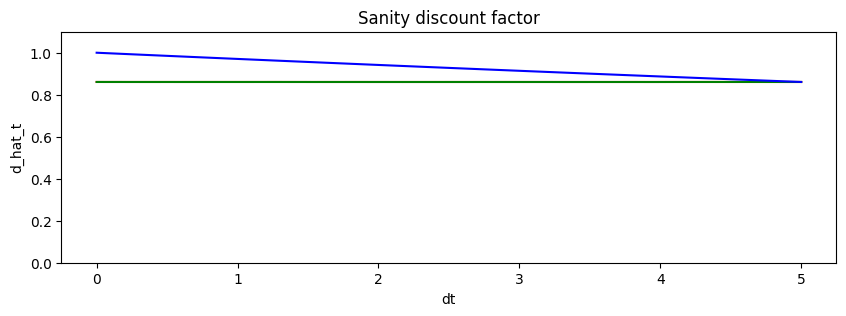

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,3))
plt.title('Sanity discount factor')
sns.lineplot(x = 'dt', y = 'd_hat_t', data = sanity, color = 'red')
sns.lineplot(x = 'dt', y = 'd_hat_tensor_t', data = sanity, color = 'green')
sns.lineplot(x = 'dt', y = 'dts', data = sanity, color = 'blue')
plt.ylim(0, 1.1)
plt.show()

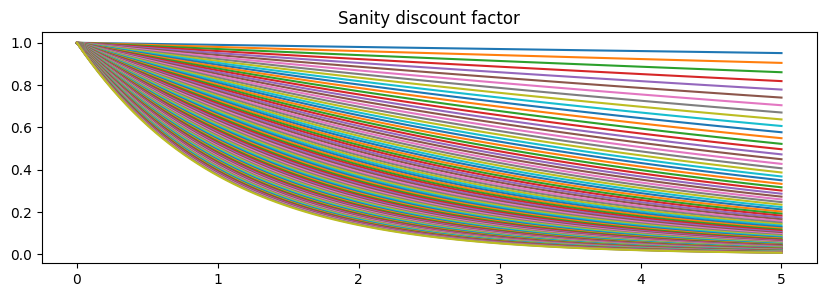

In [128]:
plt.figure(figsize = (10,3))
plt.title('Sanity discount factor')
for r in np.arange(0.01, 1.0, step = 0.01):
    sns.lineplot(x = t_unique, y = ZeroBound.D(np.array(sorted(t_unique)), r = r))
plt.show()

#### Seq2seq with feed forward neural networks

Check:
* https://towardsdatascience.com/how-to-use-custom-losses-with-custom-gradients-in-tensorflow-with-keras-e87f19d13bd5
* https://www.tensorflow.org/guide/autodiff

Current approaches:
* Traditional feed forward with two features as input features:
    * x_t - brownian path simulated
    * t - temporal instant 
    * The problem I see here is that we lose the $\frac{\delta \overline{V}_i}{\delta x_i}$, since the network is unique, thus we have: $\frac{\delta \overline{V}}{\delta x}(x_i)$
* Sequence models based:
    * The good part of this approach is $\mathcal{J} = (\nabla f_1,\dots, \nabla f_T)$ is a diagonal matrix. Since $f_i$ does not depend on $x_{j}, i \neq j$. Therefore, getting the gradients from the NN is much easier.

The idea is to include in the loss function the gradient tape to respect the model!!

In [129]:
# Tf imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

keras.backend.clear_session() 
keras.backend.set_floatx('float64')
tf.executing_eagerly()

True

In [130]:
# TODO: Write better method definitions
class LGM_model_one_step(tf.keras.Model):

    def __init__(
        self,
        n_steps,
        T = 0,
        name="LGM_NN_model_single_step",
        verbose = False,
        *,
        sigma = None,
        **kwargs
    ):
        """_summary_

        Args:
            n_steps (_type_): _description_
            intermediate_dim (int, optional): _description_. Defaults to 64.
            is_sequential (bool, optional): _description_. Defaults to False.
            name (str, optional): _description_. Defaults to "LGM_NN_model".
        """
        super(LGM_model_one_step, self).__init__(name=name, **kwargs)
        self.N = n_steps
        # Model with time and value
        input_tmp = keras.Input(shape = (2, ), 
                                name = 'input_nn')
        initializer = tf.keras.initializers.GlorotUniform(seed = 6543210)
        x = layers.Dense(units = 16,
                    activation = 'relu',
                    kernel_initializer = initializer)(input_tmp)
        output_tmp = layers.Dense(units = 1, 
                                    activation = 'relu', 
                                    kernel_initializer = initializer)(x)
        self._custom_model = keras.Model(
            inputs = input_tmp,
            outputs = output_tmp,
            name = name)
        # Metrics tracker
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        # Internal management
        self._loss_tracker_t1 = tf.keras.metrics.Mean(name="loss")
        self._loss_tracker_t2 = tf.keras.metrics.Mean(name="loss")
        self._loss_tracker_t3 = tf.keras.metrics.Mean(name="loss")
        # Internal loss results
        self._loss_tracker_t1_array = []
        self._loss_tracker_t2_array = []
        self._loss_tracker_t3_array = []
        # Duration each step
        self._deltaT = T / self.N
        # Constantes:
        print(f'T: {T}')
        self._ct = FinanceUtils.C(T, sigma_value = sigma)
        # Status variables
        self._grads, self._predictions = None, None
        # Verbose
        self._verbose = verbose
    
    @property
    def model(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return self._custom_model
    
    @property
    def metrics(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return [self.loss_tracker, self.mae_metric]
    
    def summary(self):
        """_summary_
        """
        self._custom_model.summary()

    def call(self, inputs):
        """_summary_

        Args:
            inputs (_type_): _description_

        Returns:
            _type_: _description_
        """
        # TODO: Complete the delta_x
        return self.predict(inputs)
    
    @tf.function
    def train_step(self, data):
        """_summary_

        Args:
            data (_type_): _description_

        Returns:
            _type_: _description_
        """
        x, y = data
        x = tf.Variable(x, trainable = True)
        with tf.GradientTape() as tape:
            tape.watch(x_variable)
            v = self.predict(x)
            predictions = tf.Variable(self._predictions, trainable = False)   
            loss = self._loss_lgm(x = x, v = v, predictions = predictions, N_steps = N_steps)
        # Get trainable vars
        trainable_vars = self.trainable_weights
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        # Compute metrics
        self.loss_tracker.update_state(loss)
        # Valor erroneo
        self.mae_metric.update_state(v, y)
        return {"loss": self.loss_tracker.result(), "mae": self.mae_metric.result()}
    
    def define_compiler(self, optimizer = 'adam', learning_rate = 1e-3):
        """_summary_

        Args:
            optimizer (str, optional): _description_. Defaults to 'adam'.
            learning_rate (_type_, optional): _description_. Defaults to 1e-3.
        """
        if optimizer == 'adam':
            print(f'Optimizer set to {optimizer}')
            self._optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    def custom_train_step(self, X, y = None, batch = 0, epoch = 0, start_time = None, delta_x = None):
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_, optional): _description_. Defaults to None.
            epoch (int, optional): _description_. Defaults to 0.

        Returns:
            _type_: _description_
        """
        first_dim, _ = X.shape
        batch_size = np.int64(first_dim / self.N)
        x = tf.constant(X)
        with tf.GradientTape() as tape:
            v, predictions = self.predict(x, delta_x = delta_x)
            v = tf.reshape(v, (batch_size, self.N))
            predictions = tf.reshape(predictions, (batch_size, self.N))
            loss = self.loss_lgm(x = x, 
                                 v = v, 
                                 predictions = predictions, 
                                 N_steps = self.N,
                                 verbose = self._verbose)
        grads = tape.gradient(loss, self.model.trainable_weights)
        # print(f'Grads: {len(grads)}')
        self._optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        # Compute metrics
        self.loss_tracker.update_state(loss)
        if epoch % 100 == 0:
            if start_time is None:
                print(f'Epoch {epoch} Mean loss {self.loss_tracker.result()}')
            else:
                import time
                print(f'Epoch {epoch} Batch {batch} Mean loss {self.loss_tracker.result()} Time per epoch: {(time.time() - start_time) / (epoch + 1)}s')
                print(f'\tPartial losses:\n\t\tStrike loss:{self._loss_tracker_t1.result()}\n\t\tDerivative loss: {self._loss_tracker_t2.result()}\n\t\tSteps loss: {self._loss_tracker_t3.result()}')
                self._loss_tracker_t1_array.append(self._loss_tracker_t1.result())
                self._loss_tracker_t2_array.append(self._loss_tracker_t2.result())
                self._loss_tracker_t3_array.append(self._loss_tracker_t3.result())         
        # Store losses
        return float(self.loss_tracker.result()), float(self._loss_tracker_t1.result()), float(self._loss_tracker_t2.result()), float(self._loss_tracker_t3.result())
    
    def get_losses_internal(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return self._loss_tracker_t1.result(), self._loss_tracker_t2.result(), self._loss_tracker_t3.result()
    
    def get_losses_internal_array(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return {'strike_loss': self._loss_tracker_t1_array, 
                'derivative_strike_loss': self._loss_tracker_t2_array, 
                'steps_error_loss': self._loss_tracker_t3_array}
    
    def export_model_architecture(self, dot_img_file = 'model_architectures/each_step_at_a_time.png'):
        return tf.keras.utils.plot_model(self._custom_model, to_file=dot_img_file, show_shapes=True)

    def _get_dv_dx(self, features):
        """_summary_

        Args:
            features (_type_): _description_

        Returns:
            _type_: _description_
        """
        samples, _ = features.shape
        batch_size = int(np.floor(samples / self.N))
        grads = []
        x_variable = tf.Variable(features, name = 'x')                
        with tf.GradientTape() as tape:
            tape.watch(x_variable)
            y = self._custom_model(x_variable)
        # This represents dV/dX
        grads = tape.gradient(y, {
            'x':x_variable
        })
        # Take only X partial derivatives
        self._grads = tf.reshape(grads['x'][:, 0], (batch_size, self.N))
        self._grads_prediction = grads['x'][:, 0]
        # Verbose to output
        if self._verbose:
            log_file = 'logs/20230217/grads_model.log'
            with open(log_file, 'a+') as f:
                f.write(f'Grads given X:\n')
                shape_x, shape_y = features.shape
                for x_i in range(shape_x):
                    for y_i in range(shape_y):
                        f.write(f'{features[x_i, y_i]},')
                    f.write(f'\n')
        # Sanity purposes:
        # print(f'Grads shape: {self._grads.shape}')
        return self._grads, self._grads_prediction
    
    def _get_dv_dxi(self, i, sample_idx = None):
        """_summary_

        Args:
            i (_type_): _description_
            sample_idx (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        return self._grads[:, i] if self._grads is not None else None
    
    # TODO: Separate from the model
    # Care with object attributes
    def loss_lgm(self, 
                 x: tf.Tensor, 
                 v: tf.Tensor, 
                 predictions: tf.Tensor, 
                 N_steps: np.int64, 
                 verbose: bool = False):
        """_summary_

        Args:
            x (tf.Tensor): _description_
            v (tf.Tensor): _description_
            predictions (tf.Tensor): _description_
            N_steps (np.int64): _description_

        Returns:
            _type_: _description_
        """
        # print(f'Predictions:{predictions[0,:]}, V: {v[0, :]}')
        betas = [0.02, 0.02, 1.00]
        # Careful: Using global variable...
        len_path = N_steps
        # Tiles
        tile_multiples = tf.constant([1, N_steps], tf.int64)
        samples, _ = x.shape
        batch_size = int(np.floor(samples / N_steps))
        # For f and f'
        x_reformat = tf.reshape(x[:, 0], (batch_size, N_steps))
        xn_tensor = x_reformat[:, -1]
        n_idx = int(len_path)
        # Loss given the strike function
        tn = np.float64(self._deltaT * len_path)
        strike_loss = tf.reshape(tf.math.squared_difference(v[:, -1], FinanceUtils.zero_bond_coupon(xn_tensor, tn, self._ct)), 
                                 (batch_size,1))
        # Repeat the tensor to adapt dimensions
        strike_loss = tf.tile(
            strike_loss,
            tile_multiples
        )
        strike_loss_reshaped = tf.reshape(strike_loss, [-1])
        '''print(f'Xn: {xn_tensor}')
        print(f'Ct: {self._ct}')
        print(f'Tn: {tn}')
        print(f'Zero bound coupon: {FinanceUtils.zero_bond_coupon(xn_tensor, tn, self._ct)}')'''
        # Autodiff f
        xn = tf.Variable(xn_tensor, name = 'xn', trainable = True)
        tn = tf.Variable(np.float64(self._deltaT * len_path), name = 'tn', trainable=False)
        ct = tf.Variable(np.float64(self._ct), name = 'ct', trainable=False)
        with tf.GradientTape() as tape:
            y = FinanceUtils.zero_bond_coupon(xn, tn, ct)
        grad_df = tape.gradient(y, {
            'xn':xn   
        })
        df_dxn = grad_df['xn'] if grad_df['xn'] is not None else 0. * xn
        # Verbose to output
        if verbose:
            log_file = 'logs/20230217/grads_fx.log'
            with open(log_file, 'a+') as f:
                vector = x[:, -1]
                f.write(f'X:\n')
                for x_i in vector:
                    f.write(f'{x_i},')
                f.write(f'\n')
                f.write(f'Grads: \n')
                for grad_i in vector:
                    f.write(f'{grad_i},')
                f.write(f'\n')
        # Careful: global variable
        derivative_loss = tf.reshape(
            tf.math.squared_difference(
                self._get_dv_dxi(n_idx - 1), 
                df_dxn
            ), 
            (batch_size, 1))
        # Repeat the tensor to adapt dimensions
        derivative_loss = tf.tile(
            derivative_loss,
            [1, N_steps]
        )
        derivative_loss_reshaped = tf.reshape(derivative_loss, [-1])
        # Epoch error per step
        error_per_step = tf.cumsum(tf.math.squared_difference(v, predictions), axis = 1)
        # Flatten the cumsum
        error_per_step = tf.reshape(error_per_step, [-1])
        # Record internal losses
        self._loss_tracker_t1.update_state(strike_loss)
        self._loss_tracker_t2.update_state(derivative_loss)
        self._loss_tracker_t3.update_state(error_per_step)
        # Weigth the errors
        strike_loss *= betas[0]
        derivative_loss *= betas[1]
        error_per_step *= betas[2]
        
        '''print(f'Loss shape: {tf.math.add(error_per_step, tf.math.add(strike_loss_reshaped, derivative_loss_reshaped)).shape}')
        print(f'X shape: {x.shape}')
        sys.exit()'''
        
        return tf.math.add(error_per_step, tf.math.add(strike_loss_reshaped, derivative_loss_reshaped))

    def predict(self, X:tf.Tensor, delta_x:tf.Tensor):
        """_summary_

        Args:
            X (tf.Tensor): _description_

        Returns:
            _type_: _description_
        """
        # Añadir una columna de 1's a la matriz x
        predictions = self._custom_model(X)
        # Get the gradients
        grads = self._get_dv_dx(X)[1]
        # Reshapes
        grads = tf.reshape(grads, (grads.shape[0], 1))
        delta_x = tf.reshape(delta_x, (delta_x.shape[0], 1))
        # Calculate V
        v = tf.math.add(
            predictions,
            tf.math.multiply(
                grads,
                delta_x
            )
        )
        '''print(f'V: {v[1]}\nPredictions: {predictions[1]}')
        print(f'Grads: {grads[1]}\n')
        sys.exit()'''
        return v, predictions

#### Iterative process
* F - neural network function.
* $\frac{\delta F}{\delta X_t}^i$ - gradient calculated by using the model at $i$-iteration.
* $\phi(n, x_n)$ - known terminal function.


**Path generation**

Theoretical:
$$\overline{V}_t = V(t, x_t) / N(t, x_t)$$
$$\overline{V}_{t+1} = \overline{V}_t + \frac{\delta V(t)}{\delta x_t}(x_{t + 1} - x_{t})$$
with $\phi(x_T, T) = \overline{V}_T$ known.

With NN
$$\hat{V} = F(X)$$

$$\overline{V}_{t+1} = Pred_t + \frac{\delta F(X)}{\delta x_t}(x_{t + 1} - x_{t})$$

**Loss function**
$$\mathcal{L}(\overline{V}) = \beta_1 \cdot (\overline{V}_T - \phi(T, x_T))^2 + \beta_2\cdot (\frac{\delta NN_T}{\delta x_T} - \frac{\delta \phi(T, x_T)}{\delta x_T})^2 + \beta_3\sum_{i = 1}^{T - 1}(\overline{V}_i - Pred_i)^2$$

This loss function has a problem when the architecture is single step at a time, that is $F(x,t) \in R^{2,1}$. The problem is that for each path of length $N$ produce only one single error loss. Nevertheless, we can overcome this by defining the error as a triangular inferior matrix per sample as:

$$
\mathcal{L}_{stepsLoss} = \beta_3\cdot\begin{pmatrix}
(\overline{V}_{0} - Pred_{0})^2& \dots & 0 & 0 \\
(\overline{V}_{0} - Pred_{0})^2 & \sum_{i = 0}^{2}(\overline{V}_{i} - Pred_{i})^2 & \dots & 0 \\
 & & \dots & \\
(\overline{V}_{0} - Pred_{0})^2 & \sum_{i = 0}^{2}(\overline{V}_{i} - Pred_{i})^2 & \dots & \sum_{i = 0}^{N-1}(\overline{V}_{i} - Pred_{i})^2
\end{pmatrix}
$$
After taking the `diag`

$$
\mathcal{L}_{stepsLoss} = \beta_3\cdot\begin{pmatrix}
(\overline{V}_{0} - Pred_{0})^2 \\
 \sum_{i = 0}^{2}(\overline{V}_{i} - Pred_{i})^2\\ 
 \dots\\
 \dots \\ \sum_{i = 0}^{N-1}(\overline{V}_{i} - Pred_{i})^2
\end{pmatrix}
$$

Option B:
$$
\mathcal{L}_{stepsLoss} = \beta_3\cdot\begin{pmatrix}
(\overline{V}_{0} - Pred_{0})^2 \\
 (\overline{V}_{1} - Pred_{1})^2\\ 
 \dots\\
 \dots \\ (\overline{V}_{N} - Pred_{N})^2
\end{pmatrix}
$$

$\phi(\cdot)$:
* Constant function $f(x, n) = 1$
* IRS - TODO: Check

Experiments:
* Terminal condition 1 - static case:
    * Train the network and do the sanity against the payoff for a Zero Bound Coupon $\overline{V}(x_t,t) = \frac{Z(t, x_t, T)}{N(x_t, t)}$
    * Second detail: The NN (predict vectorized) predicts the value $\overline{V}(x_t, t)$ which is our objective

In [131]:
dts = list(np.linspace(0, T, N_steps)) * len(mc_paths_transpose)
df_x_tmp = pd.DataFrame(
    zip(
        mc_paths_transpose,
    ),
    columns = [
        'paths'
    ]
)
df_x = pd.DataFrame()
df_x['xt'] = df_x_tmp.explode('paths')
df_x['dt'] = dts

2023-03-25 16:12:56.766027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "LGM_NN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_nn (InputLayer)       [(None, 20, 1)]           0         
                                                                 
 sequential_layer (GRU)      (None, 20, 64)            12864     
                                                                 
 first_dense (Dense)         (None, 20, 1)             65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
None
count    2000.000000
mean       -0.001444
std         0.010286
min        -0.038052
25%        -0.007369
50%        -0.000579
75%         0.004318
max         0.048679
Name: xt, dtype: float64
Features shape: (100, 20, 1)
Optimizer set to adam
Epoch 0 Batch 0 Mean loss 0.024140065361437823 Time per epoch: 2.

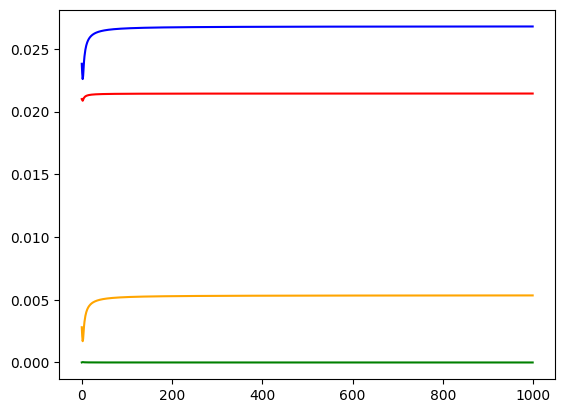

In [11]:
from model.model_lgm import LGM_model
from utils.utils.utils import MLUtils
import time
epochs = 1000
# Y 
y = None
# Custom model
lgm = LGM_model(N_steps, 64, verbose = False)
print(f'{lgm.summary()}')
# Preprocess the data
pipe = MLUtils.get_pipeline(
    transformations = ['normalization']
)
pipe.fit(
    df_x
)
df_x_preprocessed = pipe.transform(df_x)
df_x_preprocessed["xt"] = df_x_preprocessed["xt"].astype(np.float64)
print(f'{df_x_preprocessed["xt"].describe()}')
mc_paths_tranformed = df_x_preprocessed['xt'].values
mc_paths_tranformed = mc_paths_tranformed.astype(np.float64)
# Model input
x = tf.reshape(mc_paths_tranformed, (nsims, N_steps, 1))
print(f'Features shape: {x.shape}')
# Compile the model
lgm.define_compiler(optimizer = 'adam', learning_rate = 1e-3)
# Losses:
losses_split = {
    'total': [],
    'strike_loss': [],
    'strike_derivative_loss': [],
    'steps_error': []
}
# Custom iteration: 
# TODO: Fix batches when nsims is multiple of the batch_size
batch_size = 32
batches = int(np.floor(nsims / batch_size))
start_time = time.time()
for epoch in range(epochs):
    dimension = (1, batches)
    total_tmp, strike_tmp, derivative_tmp, steps_tmp = (
        np.zeros(dimension),
        np.zeros(dimension),
        np.zeros(dimension),
        np.zeros(dimension)
    )
    for batch in range(batches):
        x_batch = x[batch * batch_size: (batch + 1) * batch_size, :, :]
        el, sl, sdl, se = lgm.custom_train_step(X = x_batch, 
                                                batch = batch,
                                                epoch = epoch, 
                                                start_time = start_time)
        total_tmp[0, batch] = el
        strike_tmp[0, batch] = sl
        derivative_tmp[0, batch] = sdl
        steps_tmp[0, batch] = se
    losses_split['total'].append(
        np.mean(el)
    )
    losses_split['strike_loss'].append(
        np.mean(sl)
    )
    losses_split['strike_derivative_loss'].append(
        np.mean(sdl)
    )
    losses_split['steps_error'].append(
        np.mean(se)
    )
# Visualize errors
plt.figure()
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['total'], 
             color = 'blue')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['strike_loss'],
             color = 'red')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['strike_derivative_loss'],
             color = 'orange')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['steps_error'],
             color = 'green')
plt.show()

### Single step model

In [132]:
from utils.utils.utils import MLUtils
dts = list(np.linspace(0, T, N_steps)) * len(mc_paths_transpose)
simulation = [
    [i] * N_steps for i in range(nsims)
]
df_x_tmp = pd.DataFrame(
    zip(
        mc_paths_transpose,
        simulation
    ),
    columns = [
        'path',
        'simulation'
    ]
)
df_x = pd.DataFrame()
df_x['xt'] = df_x_tmp.explode('path')['path']
df_x['dt'] = dts
df_x['simulation'] = df_x_tmp.explode('simulation')['simulation']
df_x['_delta_x'] = df_x.groupby([
    'simulation',
])['xt'].shift(1)
df_x['_delta_x'] = (df_x['xt'] - df_x['_delta_x'])
df_x.loc[df_x._delta_x.isna(), '_delta_x'] = 0.
# Sort to get the examples in blocks
df_x.sort_values(
    [
        'simulation',
        'dt'
    ],
    inplace = True
)

Features shape: (10000, 100, 1)
                   dt
count  1000000.000000
mean         2.500000
std          1.457883
min          0.000000
25%          1.250000
50%          2.500000
75%          3.750000
max          5.000000
Features shape: (1000000, 2)
T: 5
Model: "LGM_NN_model_single_step"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_nn (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 16)                48        
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
Optimizer set to adam
Epoch 0 Batch 0 Mea

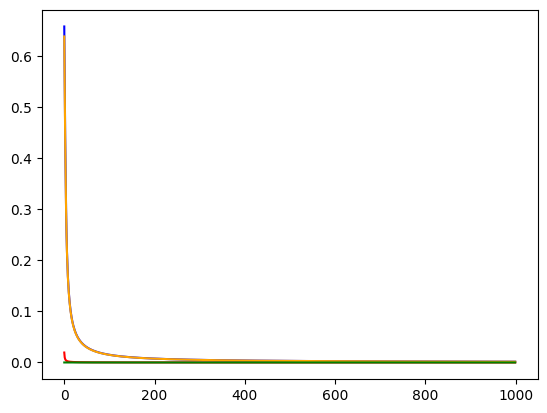

In [134]:
import time
import sys
epochs = 1000
# Y 
y = None
mc_paths_tranformed = df_x['xt'].values
mc_paths_tranformed = mc_paths_tranformed.astype(np.float64)
# Model input
x = tf.reshape(mc_paths_tranformed, (nsims, N_steps, 1))
print(f'Features shape: {x.shape}')
# Preprocess the data
pipe = MLUtils.get_pipeline(
    transformations = ['normalization']
)
pipe.fit(
    df_x
)
df_x_preprocessed = pipe.transform(df_x)
print(f'{df_x[["xt", "dt"]].describe()}')
mc_paths_tranformed = df_x[['xt', 'dt']].values
# Data used as features
x = mc_paths_tranformed.astype(np.float64)
delta_x = df_x._delta_x.values.astype(np.float64)
print(f'Features shape: {x.shape}')
# Custom model
lgm_single_step = LGM_model_one_step(N_steps, 
                                     5, 
                                     verbose = False,
                                     sigma = sigma)
print(f'{lgm_single_step.summary()}')
# Compile the model
lgm_single_step.define_compiler(optimizer = 'adam', learning_rate = 1e-3)
# Losses:
losses_split = {
    'total': [],
    'strike_loss': [],
    'strike_derivative_loss': [],
    'steps_error': []
}
# Custom iteration: 
# Batch execution with baby steps
batch_size = 100 * N_steps
batches = int(np.floor(nsims * N_steps / batch_size))
start_time = time.time()
for epoch in range(epochs):
    dimension = (1, batches)
    total_tmp, strike_tmp, derivative_tmp, steps_tmp = (
        np.zeros(dimension),
        np.zeros(dimension),
        np.zeros(dimension),
        np.zeros(dimension)
    )
    for batch in range(batches):
        x_batch = x[batch * batch_size: (batch + 1) * batch_size, :]
        delta_x_batch = delta_x[batch * batch_size: (batch + 1) * batch_size]
        el, sl, sdl, se = lgm_single_step.custom_train_step(
            X = x_batch,
            batch = batch,
            epoch = epoch, 
            start_time = start_time,
            delta_x = delta_x_batch)
        # Store partial results
        total_tmp[0, batch] = el
        strike_tmp[0, batch] = sl
        derivative_tmp[0, batch] = sdl
        steps_tmp[0, batch] = se
    losses_split['total'].append(
        el
    )
    losses_split['strike_loss'].append(
        sl
    )
    losses_split['strike_derivative_loss'].append(
        sdl
    )
    losses_split['steps_error'].append(
        se
    )
# Visualize errors
plt.figure()
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['total'], 
             color = 'blue')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['strike_loss'],
             color = 'red')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['strike_derivative_loss'],
             color = 'orange')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['steps_error'],
             color = 'green')
plt.show()

#### Sanity the NN

Once again we use the analytical solution for a ***Zero Coupon Bond***:

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ given and follows = $D(t) = e^{-rt}$, in this example with $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Discount factor (bono cupón 0 que paga 1 en T):

$$Z(x_t, t, T) = \frac{D(T)}{D(t)}exp-((H_T - H_t)x_t - \frac{1}{2}(H_T^2-H_t^2)\zeta_t) = \frac{D(T)}{D(t)}exp(-(H_T - H_t)x_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = $$
$$\frac{D(T)}{D(t)}exp(-H_Tx_t + H_tx_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = \frac{D(T)}{D(t)}exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)exp(H_tx_t + \frac{1}{2}H_t^2\zeta_t) = $$
$$D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

But we are estimating $\overline{V}_t = \frac{Z(x_t, t, T)}{N(t, x_t)}$

* Single step network

In [135]:
dts = list(np.linspace(0, T, N_steps)) * len(mc_paths_test_transpose)
simulation = [
    [i] * N_steps for i in range(nsims)
]
df_x_tmp = pd.DataFrame(
    zip(
        mc_paths_test_transpose,
        simulation
    ),
    columns = [
        'path',
        'simulation'
    ]
)
df_x = pd.DataFrame()
df_x['xt'] = df_x_tmp.explode('path')['path']
df_x['dt'] = dts
df_x['simulation'] = df_x_tmp.explode('simulation')['simulation']
df_x['_delta_x'] = df_x.groupby([
    'simulation',
])['xt'].shift(1)
df_x['_delta_x'] = (df_x['xt'] - df_x['_delta_x'])
df_x.loc[df_x._delta_x.isna(), '_delta_x'] = 0.
# Sort to get the examples in blocks
df_x.sort_values(
    [
        'simulation',
        'dt'
    ],
    inplace = True
)
# Adjust x
mc_paths_tranformed = df_x[['xt', 'dt']].values.astype(np.float64)
delta_x = df_x._delta_x.values.astype(np.float64)
# mc_paths_tranformed = np.reshape(mc_paths_tranformed, (N_steps * nsims, 2)).T
# Data used as features
x = mc_paths_tranformed.astype(np.float64)
x = tf.constant(x)
v_lgm_single_step, predictions = lgm_single_step.predict(x, delta_x)
# Adapt output
results = pd.DataFrame(
    zip(v_lgm_single_step),
    columns = ['results']
)
v_lgm_single_step = results.explode('results').values
df_x['lgm_single_step_V'] = v_lgm_single_step
df_x.head()

,xt,dt,simulation,_delta_x,lgm_single_step_V
0,0.0,0.000000,0,0.0,"tf.Tensor(0.03763562714802931, shape=(), dtype..."
0,-0.004879,0.050505,0,-0.004879,"tf.Tensor(0.04662185798987541, shape=(), dtype..."
0,-0.005446,0.101010,0,-0.000567,"tf.Tensor(0.05547819697858968, shape=(), dtype..."
0,-0.008211,0.151515,0,-0.002765,"tf.Tensor(0.06441828827737255, shape=(), dtype..."
0,-0.007687,0.202020,0,0.000524,"tf.Tensor(0.07327398246975925, shape=(), dtype..."


In [136]:
v_df = pd.DataFrame(
    zip(df_x.lgm_single_step_V.values,
        df_x.dt.values, 
        df_x.xt.values), 
    columns = ['V_hat_single_step', 
               'deltat', 
               'xt'])
t_unique = v_df.deltat.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = sigma) for dt in t_unique}
v_df['ct'] = v_df.apply(lambda x: dict_C[x['deltat']], axis = 1)
v_df.head()

,V_hat_single_step,deltat,xt,ct
0,"tf.Tensor(0.03763562714802931, shape=(), dtype...",0.000000,0.000000,0.000000
1,"tf.Tensor(0.04662185798987541, shape=(), dtype...",0.050505,-0.004879,0.000005
2,"tf.Tensor(0.05547819697858968, shape=(), dtype...",0.101010,-0.005446,0.000010
3,"tf.Tensor(0.06441828827737255, shape=(), dtype...",0.151515,-0.008211,0.000015
4,"tf.Tensor(0.07327398246975925, shape=(), dtype...",0.202020,-0.007687,0.000020


In [138]:
# Z value
v_df['V'] = v_df.apply(
    lambda x: 
        ZeroBound.Z(x.xt, x.deltat, T, x.ct) / ZeroBound.N(x.deltat, x.xt, x.ct), 
        axis = 1)
# Zero bound coupon
v_df['ZeroBound'] = v_df.apply(
    lambda x: 
        FinanceUtils.zero_bond_coupon(x.xt, x.deltat, x.ct), 
        axis = 1)
# N for sanity
v_df['N'] = v_df.apply(
    lambda x: 
        ZeroBound.N(x.deltat, x.xt, x.ct), 
        axis = 1)

KeyboardInterrupt: 

In [121]:
v_df.loc[
    v_df.deltat == T    
][['V', 'V_hat_single_step']].head(20)

,V,V_hat_single_step
19,0.977793,"tf.Tensor(0.8686210853093915, shape=(), dtype=..."
39,0.971777,"tf.Tensor(0.86220892651964, shape=(), dtype=fl..."
59,0.979331,"tf.Tensor(0.8701894280170817, shape=(), dtype=..."
79,0.963710,"tf.Tensor(0.8529737392796526, shape=(), dtype=..."
99,0.975743,"tf.Tensor(0.8680289303919773, shape=(), dtype=..."
119,0.979094,"tf.Tensor(0.8691275089085585, shape=(), dtype=..."
139,0.967253,"tf.Tensor(0.8574204671926648, shape=(), dtype=..."
159,0.967963,"tf.Tensor(0.857494263059314, shape=(), dtype=f..."
179,0.967502,"tf.Tensor(0.8575659270133166, shape=(), dtype=..."
199,0.971528,"tf.Tensor(0.8624734780312538, shape=(), dtype=..."
